In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from hurst import compute_Hc
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [5]:
df1 = pd.read_csv('data/saderat_bank.csv')
df2 = pd.read_csv('data/Iran.Khodro.csv')
df3 = pd.read_csv('data/S_Mobarakeh.Steel.csv')

### ================== پیش‌پردازش اصلی ==================

In [6]:
def preprocess(df):
    df = df.rename(columns={
        '<TICKER>': 'ticker', '<DTYYYYMMDD>': 'date', '<HIGH>': 'high',
        '<FIRST>': 'first', '<LOW>': 'low', '<CLOSE>': 'close',
        '<VALUE>': 'value', '<VOL>': 'vol', '<OPENINT>': 'openint',
        '<PER>': 'per', '<OPEN>': 'open', '<LAST>': 'last'
    })
    print("\n                ", df['ticker'].iloc[0])
    print("Duplicates:", df.duplicated().sum())
    print("Initial missing values:", df.isnull().sum())

    df['vol'] = df['vol'].replace({'M': '*1e6', 'B': '*1e9'}, regex=True).map(pd.eval)

    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df = df.sort_values(by='date').reset_index(drop=True)

    return df

df1 = preprocess(df1)
df2 = preprocess(df2)
df3 = preprocess(df3)


                 Saderat Bank
Duplicates: 0
Initial missing values: ticker     0
date       0
first      0
high       0
low        0
close      0
value      0
vol        0
openint    0
per        0
open       0
last       0
dtype: int64

                 Iran.Khodro
Duplicates: 0
Initial missing values: ticker     0
date       0
first      0
high       0
low        0
close      0
value      0
vol        0
openint    0
per        0
open       0
last       0
dtype: int64

                 S*Mobarakeh.Steel
Duplicates: 0
Initial missing values: ticker     0
date       0
first      0
high       0
low        0
close      0
value      0
vol        0
openint    0
per        0
open       0
last       0
dtype: int64


### ================== ویژگی‌های تکنیکال ==================

In [7]:
def add_technical_indicators(df):
    # Moving Averages
    df['MA3'] = df['close'].rolling(window=3).mean().shift(1)
    df['MA5'] = df['close'].rolling(window=5).mean().shift(1)
    df['MA10'] = df['close'].rolling(window=10).mean().shift(1)
    df['MA20'] = df['close'].rolling(window=20).mean().shift(1)
    df['MA50'] = df['close'].rolling(window=50).mean().shift(1)

    # Bollinger Bands
    df['std_20'] = df['close'].rolling(window=20).std().shift(1)
    df['Bollinger_Upper'] = df['MA20'] + (2 * df['std_20'])
    df['Bollinger_Lower'] = df['MA20'] - (2 * df['std_20'])

    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = (ema12 - ema26).shift(1)
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean().shift(1)

    # Lag features
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['close'].shift(lag)

    # Time-based features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month

    #RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = (100 - (100 / (1 + rs))).shift(1)

    # Volatility
    df['Volatility'] = df['close'].rolling(window=10).std().shift(1)
    
    df['VWAP'] = (df['close'] * df['vol']).cumsum() / df['vol'].cumsum().shift(1)

    # پاک‌سازی نال‌ها
    # df = df.fillna(method='ffill')
    df = df.dropna()

    return df

df1 = add_technical_indicators(df1)
df2 = add_technical_indicators(df2)
df3 = add_technical_indicators(df3)

In [8]:
# def HUR(name, df):
#     ts = df['close'].dropna()
#     H1, _, _ = compute_Hc(ts, kind='change', simplified=True)
#     print(f"Hurst exponent ({name}, change): {H1:.3f}")

#     ts_filtered = ts[ts > 0.01]
#     H2, _, _ = compute_Hc(ts_filtered, kind='price', simplified=True)
#     print(f"Hurst exponent ({name}, price): {H2:.3f}")

# # محاسبه Hurst برای دیتافریم‌های اصلی
# HUR("SA", df1)
# HUR("IK", df2)
# HUR("FE", df3)

### تقسیم‌بندی داده‌ها

In [9]:

train_data = df1[(df1['date'] >= '2010-01-01') & (df1['date'] <= '2021-12-31')]
test_data = df1[(df1['date'] >= '2022-01-01') & (df1['date'] <= '2025-05-21')]

# train_data = df2[(df2['date'] >= '2010-01-01') & (df2['date'] <= '2021-12-31')]
# test_data = df2[(df2['date'] >= '2022-01-01') & (df2['date'] <= '2025-05-21')]

# train_data = df3[(df3['date'] >= '2010-01-01') & (df3['date'] <= '2021-12-31')]
# test_data = df3[(df3['date'] >= '2022-01-01') & (df3['date'] <= '2025-05-21')]
# train_data, test_data


In [10]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot_acf(train_data['close'], lags=40)
# plot_pacf(train_data['close'], lags=40)
# plt.show()


### نرمال‌سازی

In [11]:

def scaling(df1, df2): 
    scaler = MinMaxScaler()
    features = ['close','MA3','MA5', 'MA10', 'MA20', 'MA50', 'first',
                'Bollinger_Upper', 'Bollinger_Lower','RSI',
            'MACD', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
            'day_of_week', 'month', 'Volatility','vol']
    scaler.fit(df1[features])
    df1[features] = scaler.transform(df1[features])
    df2[features] = scaler.transform(df2[features])
    return df1, df2
train_data, test_data = scaling(train_data.copy(), test_data.copy())    
    

In [12]:
# numeric_df = train_data[['close','MA3','MA5', 'MA10', 'MA20', 'MA50',
#        'std_20', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD','VWAP',
#        'MACD_signal', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
#        'day_of_week', 'month', 'Volatility']]

# corr = numeric_df.corr()  # ماتریس همبستگی
# plt.figure(figsize=(10, 8))  # اندازه کلی نمودار
# sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 7})

# plt.show()

XGBoost 

In [13]:
features = ['MA3','MA5', 'MA10', 'MA20', 'MA50',
       'std_20', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD','VWAP',
       'MACD_signal', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'day_of_week', 'month', 'Volatility']

target = 'close'

# Lag-0 (استفاده از ویژگی‌ها برای پیش‌بینی قیمت همان روز)
X0 = df1[features]
y0 = df1[target]
# Lag-1 (ویژگی‌ها یک روز به عقب شیفت داده می‌شن برای پیش‌بینی امروز)
X1 = df1[features].shift(1).dropna()
y1 = df1[target].iloc[1:]

# هم‌ترازسازی طول X1 و y1
X1 = X1.iloc[:len(y1)]

# تقسیم دیتای lag-0
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=42)
# تقسیم دیتای lag-1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [14]:
# پارامترهای XGBoost برای جستجوی تصادفی
param_dist = {
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 2, 3],
    "gamma": np.linspace(0, 0.4, 5),
    "reg_alpha": np.linspace(0, 0.5, 5),
    "reg_lambda": np.linspace(0, 0.5, 5)
}

# مدل برای lag-0
xgb0 = xgb.XGBRegressor(random_state=42)
rs0 = RandomizedSearchCV(xgb0, param_distributions=param_dist, n_iter=20, cv=3, verbose=0, random_state=42, n_jobs=-1)
rs0.fit(X0_train, y0_train)

# مهم‌ترین فیچرها برای lag-0
importances0 = pd.Series(rs0.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)
top10_lag0 = importances0.head(10).index.tolist()

# مدل برای lag-1
xgb1 = xgb.XGBRegressor(random_state=42)
rs1 = RandomizedSearchCV(xgb1, param_distributions=param_dist, n_iter=20, cv=3, verbose=0, random_state=42, n_jobs=-1)
rs1.fit(X1_train, y1_train)

# مهم‌ترین فیچرها برای lag-1
importances1 = pd.Series(rs1.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)
top10_lag1 = importances1.head(10).index.tolist()

# استخراج اندیکاتورهای دوگانه مهم
dual_important = list(set(top10_lag0) & set(top10_lag1))

print("Top 10 Lag-0:", top10_lag0)
print("Top 10 Lag-1:", top10_lag1)
print("📌 Dual Important Indicators:", dual_important)


Top 10 Lag-0: ['lag_1', 'MA3', 'Bollinger_Upper', 'Bollinger_Lower', 'std_20', 'lag_5', 'VWAP', 'MA50', 'lag_4', 'MA20']
Top 10 Lag-1: ['lag_1', 'Bollinger_Upper', 'MA3', 'Bollinger_Lower', 'VWAP', 'std_20', 'lag_4', 'lag_5', 'MA5', 'MACD']
📌 Dual Important Indicators: ['Bollinger_Upper', 'VWAP', 'std_20', 'lag_4', 'lag_1', 'MA3', 'Bollinger_Lower', 'lag_5']


##### features

 Heat Map Features

In [ ]:
# features = [
#         'MA3','MA5',# 'MA10', 'MA20', 'MA50',
#         'lag_1', 'lag_2',# 'lag_3',# 'lag_4', 'lag_5',
#         'std_20', 'Bollinger_Upper',# 'Bollinger_Lower',
#         'Volatility', 
#         'VWAP',
#         #'MACD','MACD_signal',
#         #'day_of_week', 'month',
#         ]


 XGBoost Features

In [23]:
features = [
        'MA3',#'MA5',# 'MA10', 'MA20', 'MA50',
        'lag_1','lag_4', 'lag_5',# 'lag_2',# 'lag_3',# 
        'std_20', 'Bollinger_Upper', 'Bollinger_Lower',
        # 'Volatility', 
        'VWAP',
        #'MACD','MACD_signal',
        #'day_of_week', 'month',
        ]

### ================== مدل ARIMAX ==================

In [24]:
exog_train = train_data[features]
exog_test = test_data[features]

model_arimax = ARIMA(train_data['close'], exog=exog_train, order=(1, 0, 2))
arimax_fit = model_arimax.fit()

arimax_predictions = arimax_fit.forecast(steps=len(test_data), exog=exog_test)
arimax_predictions.index = test_data['date']


y_true = test_data['close'].values
y_pred = arimax_predictions.values
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rsq = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'ARIMAX RESULT : [MSE: {mse:.3f}, MAE: {mae:.3f}, R²: {rsq:.5f}, MAPE: {mape:.3f}% ]')


ARIMAX RESULT : [MSE: 0.000, MAE: 0.007, R²: 0.97540, MAPE: 3.643% ]


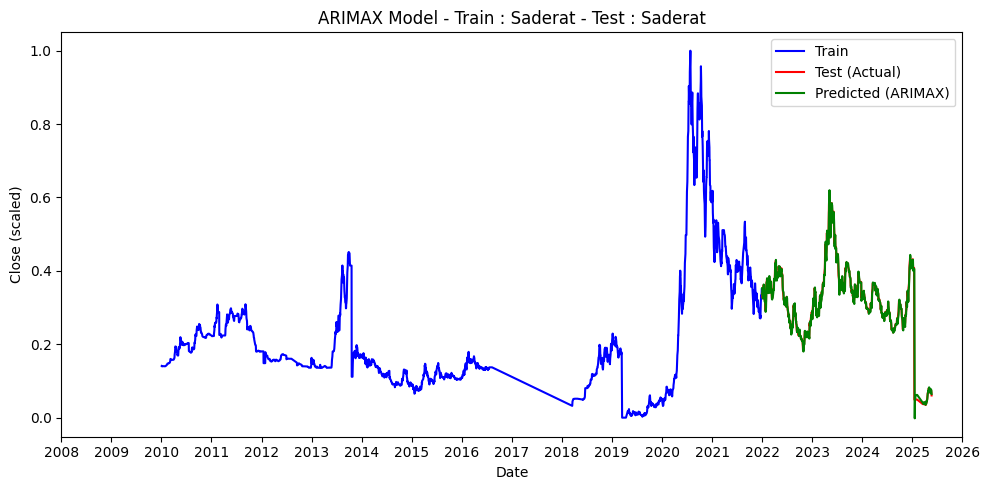

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_data['date'], train_data['close'], label='Train', color='blue')
plt.plot(test_data['date'], test_data['close'], label='Test (Actual)', color='red')
plt.plot(arimax_predictions, label='Predicted (ARIMAX)', color='green', #linestyle='--'
)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(pd.to_datetime('2008'), pd.to_datetime('2026'))
# plt.title('ARIMAX Model - Saderat Bank')
plt.title('ARIMAX Model - Train : Saderat - Test : Saderat')
# plt.title('ARIMAX Model - Iran Khodro')
plt.xlabel('Date')
plt.ylabel('Close (scaled)')
plt.legend()
plt.tight_layout()
plt.show()


### ========= تابع ساخت توالی‌ها و تابع نرمال‌سازی =========

In [26]:

time_step = 90

# ==================  فیچرها ==================
def scaling(df1, df2, features): 
    scaler = MinMaxScaler()
    scaler.fit(df1[features])
    df1[features] = scaler.transform(df1[features])
    df2[features] = scaler.transform(df2[features])
    return df1, df2

# ================== ==================
def create_dataset(X, Y, time_step=90):
    Xs, Ys = [], []
    for i in range(time_step, len(X)):
        Xs.append(X[i - time_step:i])
        Ys.append(Y[i-1])
    return np.array(Xs), np.array(Ys)

# کپی برای حفظ دیتا اصلی
train_data_raw = train_data.copy()
test_data_raw = test_data.copy()

# 1. اسکیل کردن فیچرها
train_data, test_data = scaling(train_data_raw, test_data_raw, features)

# 2. اسکیل کردن close
scaler_close = MinMaxScaler()
train_data['close'] = scaler_close.fit_transform(train_data[['close']])
test_data['close'] = scaler_close.transform(test_data[['close']])

# 3. جدا کردن X و Y
X_train_full = train_data[features].values
Y_train_full = train_data['close'].values

X_test_full = test_data[features].values
Y_test_full = test_data['close'].values

# 4. ساخت دنباله‌ها
X_train, Y_train = create_dataset(X_train_full, Y_train_full, time_step)
X_test, Y_test = create_dataset(X_test_full, Y_test_full, time_step)

### ================== مدل GRU ==================

In [27]:

n_features = X_train.shape[2]

model_gru = Sequential()
model_gru.add(GRU(units=128, return_sequences=True, input_shape=(time_step, n_features)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=32))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(1))

# کامپایل
optimizer = Adam(learning_rate=0.0005)
model_gru.compile(loss='mean_squared_error', optimizer=optimizer)

# آموزش
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model_gru.fit(X_train, Y_train,
                        epochs=10,  # می‌تونی بیشترش هم بکنی
                        batch_size=32,
                        validation_split=0.1,
                        callbacks=[early_stop],
                        verbose=1)

# ================== پیش‌بینی ==================
gru_predictions = model_gru.predict(X_test)

# برگردوندن به مقیاس واقعی
gru_predictions_real = scaler_close.inverse_transform(gru_predictions)
Y_test_real = scaler_close.inverse_transform(Y_test.reshape(-1, 1))

# ================== ارزیابی ==================
mse_gru = mean_squared_error(Y_test_real, gru_predictions_real)
mae_gru = mean_absolute_error(Y_test_real, gru_predictions_real)
rsq_gru = 1 - (np.sum((Y_test_real - gru_predictions_real) ** 2) / np.sum((Y_test_real - np.mean(Y_test_real)) ** 2))
mape = np.mean(np.abs((Y_test_real - gru_predictions_real) / Y_test_real)) * 100


print(f" GRU Results: [ MSE: {mse_gru:.4f}, MAE: {mae_gru:.4f}, R²: {rsq_gru:.4f},  MAPE: {mape:.4f}% ]")


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - loss: 0.0124 - val_loss: 0.0038
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0013 - val_loss: 8.4161e-04
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - loss: 0.0010 - val_loss: 8.5329e-04
Epoch 9/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 10/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 0.0012 - val_loss: 0.0011
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
 GRU Results: [ MSE: 0.0008, MAE: 0.0155, R²: 0.9249,  MAPE: 9.1488% ]


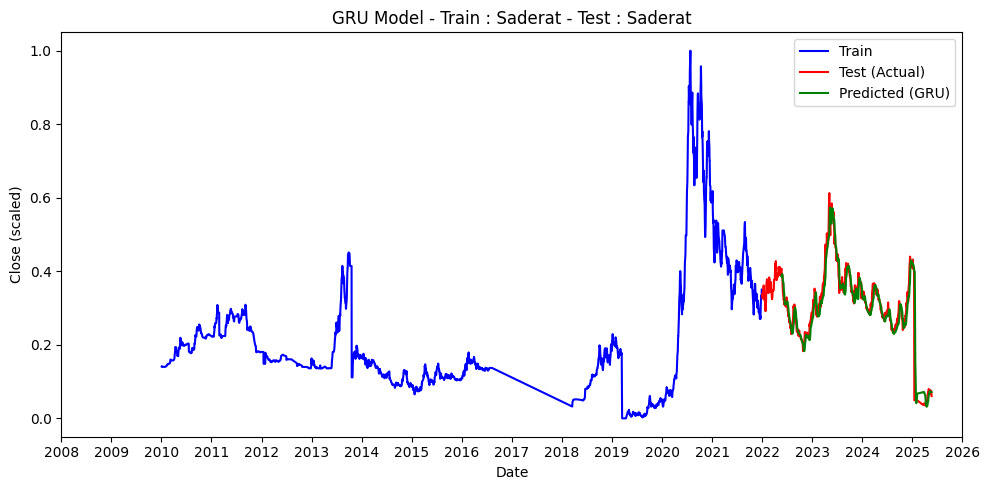

MSE (GRU): 0.0008
MAE (GRU): 0.0155
MAPE(GRU): 9.1488
R-Squared (GRU): 0.9249


In [28]:
# تنظیم تاریخ‌ها برای نمودار
adjusted_dates_test = test_data['date'].iloc[time_step:].reset_index(drop=True)

# ترسیم نمودار
plt.figure(figsize=(10, 5))
plt.plot(train_data['date'], train_data['close'], label='Train', color='blue')
plt.plot(test_data['date'], test_data['close'], label='Test (Actual)', color='red')
plt.plot(adjusted_dates_test, gru_predictions, label='Predicted (GRU)', color='green')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.title('GRU Model - Close Price Forecast')
# plt.title('GRU Model - S*Mobarakeh.Steel')
plt.title('GRU Model - Train : Saderat - Test : Saderat')


plt.xlabel('Date')
plt.ylabel('Close (scaled)')
plt.xlim(pd.to_datetime('2008'), pd.to_datetime('2026'))
plt.legend()
plt.tight_layout()
plt.show()

# چاپ ارزیابی‌ها
print(f"MSE (GRU): {mse_gru:.4f}")
print(f"MAE (GRU): {mae_gru:.4f}")
print(f"MAPE(GRU): {mape:.4f}")
print(f"R-Squared (GRU): {rsq_gru:.4f}")


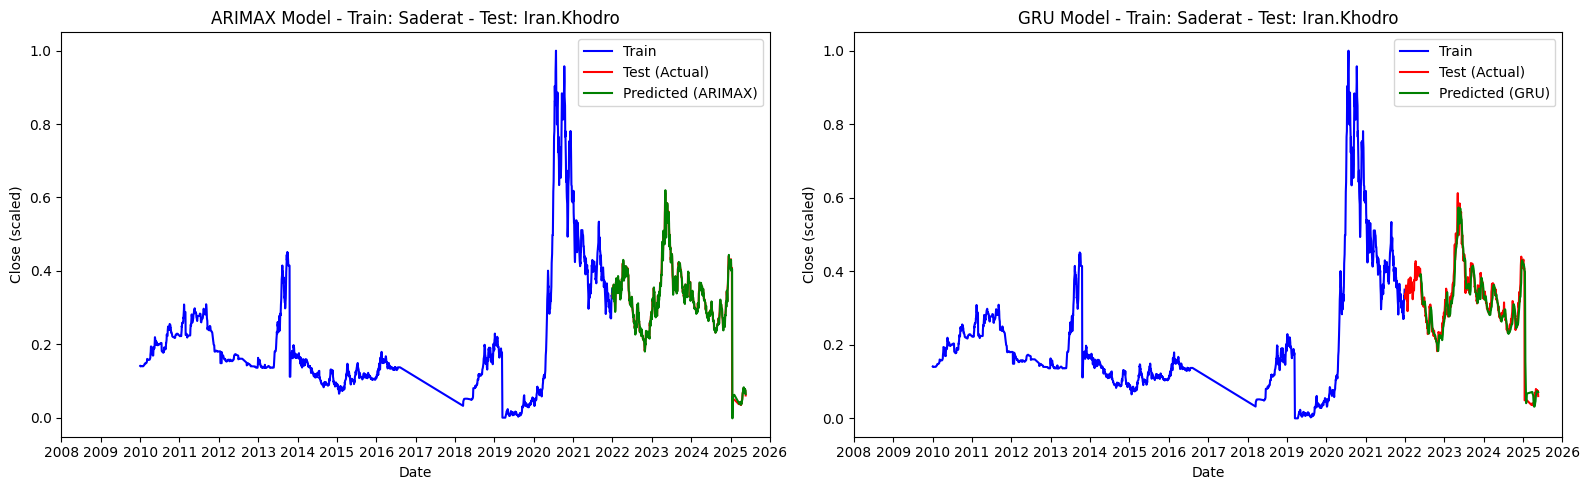

MSE (GRU): 0.0008
MAE (GRU): 0.0155
MAPE(GRU): 9.1488
R-Squared (GRU): 0.9249


In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))  # 1 ردیف، 2 ستون

# --- نمودار ARIMAX ---
axes[0].plot(train_data['date'], train_data['close'], label='Train', color='blue')
axes[0].plot(test_data['date'], test_data['close'], label='Test (Actual)', color='red')
axes[0].plot(arimax_predictions, label='Predicted (ARIMAX)', color='green')

axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[0].set_xlim(pd.to_datetime('2008'), pd.to_datetime('2026'))
axes[0].set_title('ARIMAX Model - Train: Saderat - Test: Iran.Khodro')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close (scaled)')
axes[0].legend()

# --- نمودار GRU ---
adjusted_dates_test = test_data['date'].iloc[time_step:].reset_index(drop=True)
axes[1].plot(train_data['date'], train_data['close'], label='Train', color='blue')
axes[1].plot(test_data['date'], test_data['close'], label='Test (Actual)', color='red')
axes[1].plot(adjusted_dates_test, gru_predictions, label='Predicted (GRU)', color='green')

axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1].set_xlim(pd.to_datetime('2008'), pd.to_datetime('2026'))
axes[1].set_title('GRU Model - Train: Saderat - Test: Iran.Khodro')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Close (scaled)')
axes[1].legend()

plt.tight_layout()
plt.show()

# چاپ ارزیابی‌ها
print(f"MSE (GRU): {mse_gru:.4f}")
print(f"MAE (GRU): {mae_gru:.4f}")
print(f"MAPE(GRU): {mape:.4f}")
print(f"R-Squared (GRU): {rsq_gru:.4f}")
